## Jigsaw Unintended Bias in Toxicity Classification

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'jigsaw-snapshot:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1498861%2F2476686%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240212%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240212T124756Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D526616c1a4340bb9383c4925161a15ccb60fdfc43aaf855ed2e97a1ab7be29e6e3e5b15218e76820c0cc260ea010a0a99e9020fbcd2677278715a82becf133bc1845153bc4631af2460634e49e2adc090ed2fcbd7d6979093888b2cd38466688a10bf7bd0630ae27347d76638670c6f1d522173a6fe8427c5d9785c2edf8b7842bab9ff83cd65c98f6d1092dc1b9d77486d7d07ce2f4a0e2bf4dbfc5a16f9d1fecdac5ef577b937d003832d7e054aefd620d0dc513c48f4ea9bde4ca018523adc91131010f1584f6caa2771b1b87e2779a173ae281cf516b5b6bbc64998ba1e0a6b395e4dbc77636fb5531bfa6cff8ff189082729e68c0480d95a6c84829c097'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 14288063 bytes downloaded
Downloaded and uncompressed: jigsaw-snapshot
Data source import complete.


In [2]:
# Set up feedback system

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Get the same results each time
np.random.seed(0)

# Load the training data
data = pd.read_csv("../input/jigsaw-snapshot/data.csv")
comments = data["comment_text"]
target = (data["target"]>0.7).astype(int)

# Break into training and test sets
comments_train, comments_test, y_train, y_test = train_test_split(comments, target, test_size=0.30, stratify=target)

# Get vocabulary from training data
vectorizer = CountVectorizer()
vectorizer.fit(comments_train)

# Get word counts for training and test sets
X_train = vectorizer.transform(comments_train)
X_test = vectorizer.transform(comments_test)

# Preview the dataset
print("Data successfully loaded!\n")
print("Sample toxic comment:", comments_train.iloc[22])
print("Sample not-toxic comment:", comments_train.iloc[17])

Data successfully loaded!

Sample toxic comment: Too dumb to even answer.
Sample not-toxic comment: No they aren't.


Run the next code cell without changes to use the data to train a simple model.  The output shows the accuracy of the model on some test data.

In [3]:
data

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0000,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.000000,4,47
1,239607,0.912500,Yet call out all Muslims for the acts of a few...,0.050000,0.237500,0.612500,0.887500,0.1125,0.0,0.0,...,26670,approved,0,0,0,1,0,0.000000,4,80
2,239612,0.830769,This bitch is nuts. Who would read a book by a...,0.107692,0.661538,0.338462,0.830769,0.0000,0.0,0.0,...,26674,rejected,0,0,0,0,0,0.061538,4,65
3,240311,0.968750,You're an idiot.,0.031250,0.062500,0.000000,0.968750,0.0000,NaN,NaN,...,32846,rejected,0,0,0,0,0,0.000000,0,32
4,240329,0.900000,Who cares!? Stark trek and Star Wars fans are ...,0.100000,0.200000,0.000000,0.900000,0.0000,NaN,NaN,...,32846,rejected,0,0,0,0,0,0.300000,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90897,957507,0.166667,Methinks Bishop Braxton doth protest too much ...,0.000000,0.000000,0.166667,0.166667,0.0000,0.0,0.0,...,166439,approved,0,0,0,6,0,0.000000,10,6
90898,5363032,0.000000,Sounds pretty speculative to me. But i'm a sp...,0.000000,0.000000,0.000000,0.000000,0.0000,NaN,NaN,...,340892,approved,3,0,0,1,0,0.000000,0,4
90899,5910478,0.166667,Seriously!\nVery proud of our 'domestic progra...,0.000000,0.000000,0.166667,0.000000,0.0000,NaN,NaN,...,374717,approved,0,0,0,0,1,0.000000,0,6
90900,1052094,0.000000,Hawaii food is mostly GMO loaded with chemical...,0.000000,0.000000,0.000000,0.000000,0.0000,NaN,NaN,...,315373,approved,0,0,0,0,1,0.000000,0,6


In [4]:
from sklearn.linear_model import LogisticRegression

# Train a model and evaluate performance on test dataset
classifier = LogisticRegression(max_iter=2000)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

# Function to classify any string
def classify_string(string, investigate=False):
    prediction = classifier.predict(vectorizer.transform([string]))[0]
    if prediction == 0:
        print("NOT TOXIC:", string)
    else:
        print("TOXIC:", string)

Accuracy: 0.9304755967877966


In [5]:
# Comment to pass through the model
my_comment = "i have a black friend"

# Do not change the code below
classify_string(my_comment)


TOXIC: i have a black friend


In [6]:
coefficients = pd.DataFrame({"word": sorted(list(vectorizer.vocabulary_.keys())), "coeff": classifier.coef_[0]})
coefficients.sort_values(by=['coeff']).tail(10)

,word,coeff
20745,fools,6.278998
34211,moron,6.332776
16844,dumb,6.359718
12907,crap,6.490237
38317,pathetic,6.554479
25850,idiotic,7.004897
49802,stupidity,7.553515
25858,idiots,8.601835
25847,idiot,8.604702
49789,stupid,9.277682


In [7]:
# Set the value of new_comment
new_comment = "i have a muslim friend"

# Do not change the code below
classify_string(new_comment)
coefficients[coefficients.word.isin(new_comment.split())]

TOXIC: i have a muslim friend


,word,coeff
21256,friend,-0.131099
24049,have,-0.072253
34692,muslim,1.768477


## Credit Card Applicants

1. Demographic parity / statistical parity
Demographic parity says the model is fair if the composition of people who are selected by the model matches the group membership percentages of the applicants.

A nonprofit is organizing an international conference, and 20,000 people have signed up to attend. The organizers write a ML model to select 100 attendees who could potentially give interesting talks at the conference. Since 50% of the attendees will be women (10,000 out of 20,000), they design the model so that 50% of the selected speaker candidates are women.

2. Equal opportunity
Equal opportunity fairness ensures that the proportion of people who should be selected by the model ("positives") that are correctly selected by the model is the same for each group. We refer to this proportion as the true positive rate (TPR) or sensitivity of the model.

A doctor uses a tool to identify patients in need of extra care, who could be at risk for developing serious medical conditions. (This tool is used only to supplement the doctor's practice, as a second opinion.) It is designed to have a high TPR that is equal for each demographic group.

3. Equal accuracy
Alternatively, we could check that the model has equal accuracy for each group. That is, the percentage of correct classifications (people who should be denied and are denied, and people who should be approved who are approved) should be the same for each group. If the model is 98% accurate for individuals in one group, it should be 98% accurate for other groups.

A bank uses a model to approve people for a loan. The model is designed to be equally accurate for each demographic group: this way, the bank avoids approving people who should be rejected (which would be financially damaging for both the applicant and the bank) and avoid rejecting people who should be approved (which would be a failed opportunity for the applicant and reduce the bank's revenue).

4. Group unaware / "Fairness through unawareness"
Group unaware fairness removes all group membership information from the dataset. For instance, we can remove gender data to try to make the model fair to different gender groups. Similarly, we can remove information about race or age.

One difficulty of applying this approach in practice is that one has to be careful to identify and remove proxies for the group membership data. For instance, in cities that are racially segregated, zip code is a strong proxy for race. That is, when the race data is removed, the zip code data should also be removed, or else the ML application may still be able to infer an individual's race from the data. Additionally, group unaware fairness is unlikely to be a good solution for historical bias.

In [8]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'synthetic-credit-card-approval:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1154765%2F1953634%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240212%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240212T132323Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D65b90c7ad5c1ec71f83326708778b9ae516a1796bfa8c1dd24dbc3e99ae80e78cfc91f53c576ab26248e4d156adf45f9d2d5df0233d5e107224d8e93cce90389caceb01affaa5bdc13e2aeac6f4b35cf7d19cfb4c79d072d710feaee797cc9ba5fa23e0597bd362a93ed63b39b11bbf8d86efa486de52988667f7c912aba97c260b7d20e12292636cb2b1be9d91e89bc328d26ec95b925897f72c0b7d28241cfb5d2bdc9057e62142250a36e18cd6916f035571ed4fce2148b50c3383eb9d9caa7b862a9cc7daac0da061375b7ca4590a84619eadf31fc555176584d2e005c7f4bbb6b52c9081248a8620d3029a62df7f233a73d9047b2b45d7fd807233152df'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2568113 bytes downloaded
Downloaded and uncompressed: synthetic-credit-card-approval
Data source import complete.


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data, separate features from target
data = pd.read_csv("../input/synthetic-credit-card-approval/synthetic_credit_card_approval.csv")
X = data.drop(["Target"], axis=1)
y = data["Target"]

# Break into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Preview the data
print("Data successfully loaded!\n")
X_train.head()

Data successfully loaded!



,Num_Children,Group,Income,Own_Car,Own_Housing
288363,1,1,40690,0,1
64982,2,0,75469,1,0
227641,1,1,70497,1,1
137672,1,1,61000,0,0
12758,1,1,56666,1,1


Total approvals: 38246
Group A: 8028 (20.99% of approvals)
Group B: 30218 (79.01% of approvals)

Overall accuracy: 94.79%
Group A: 94.56%
Group B: 95.02%

Sensitivity / True positive rate:
Group A: 77.23%
Group B: 98.03%


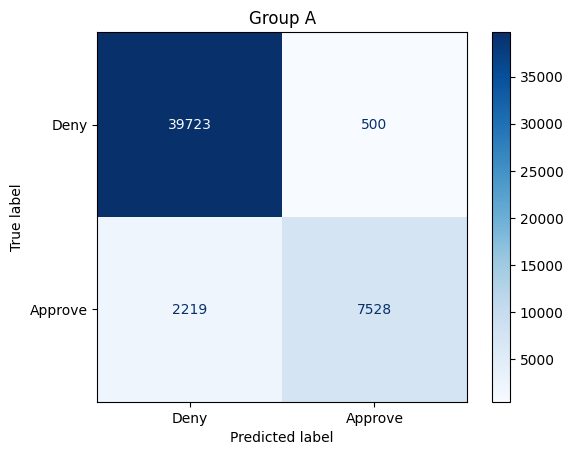

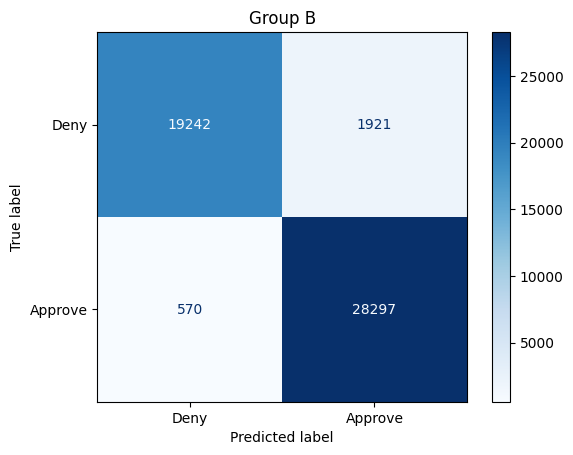

In [10]:
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train a model and make predictions
model_baseline = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
model_baseline.fit(X_train, y_train)
preds_baseline = model_baseline.predict(X_test)

# Function to plot confusion matrix
def plot_confusion_matrix(estimator, X, y_true, y_pred, display_labels=["Deny", "Approve"],
                          include_values=True, xticks_rotation='horizontal', values_format='',
                          normalize=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    return cm, disp.plot(include_values=include_values, cmap=cmap, xticks_rotation=xticks_rotation,
                     values_format=values_format)

# Function to evaluate the fairness of the model
def get_stats(X, y, model, group_one, preds):

    y_zero, preds_zero, X_zero = y[group_one==False], preds[group_one==False], X[group_one==False]
    y_one, preds_one, X_one = y[group_one], preds[group_one], X[group_one]

    print("Total approvals:", preds.sum())
    print("Group A:", preds_zero.sum(), "({}% of approvals)".format(round(preds_zero.sum()/sum(preds)*100, 2)))
    print("Group B:", preds_one.sum(), "({}% of approvals)".format(round(preds_one.sum()/sum(preds)*100, 2)))

    print("\nOverall accuracy: {}%".format(round((preds==y).sum()/len(y)*100, 2)))
    print("Group A: {}%".format(round((preds_zero==y_zero).sum()/len(y_zero)*100, 2)))
    print("Group B: {}%".format(round((preds_one==y_one).sum()/len(y_one)*100, 2)))

    cm_zero, disp_zero = plot_confusion_matrix(model, X_zero, y_zero, preds_zero)
    disp_zero.ax_.set_title("Group A")
    cm_one, disp_one = plot_confusion_matrix(model, X_one, y_one, preds_one)
    disp_one.ax_.set_title("Group B")

    print("\nSensitivity / True positive rate:")
    print("Group A: {}%".format(round(cm_zero[1,1] / cm_zero[1].sum()*100, 2)))
    print("Group B: {}%".format(round(cm_one[1,1] / cm_one[1].sum()*100, 2)))

# Evaluate the model
get_stats(X_test, y_test, model_baseline, X_test["Group"]==1, preds_baseline)

* The model approved 38246 people for a credit card. Of these individuals, 8028 belonged to Group A, and 30218 belonged to Group B.
* The model is 94.56% accurate for Group A, and 95.02% accurate for Group B. * These percentages can be calculated directly from the confusion matrix; for instance, for Group A, the accuracy is (39723+7528)/(39723+500+2219+7528).
* The true positive rate (TPR) for Group A is 77.23%, and the TPR for Group B is 98.03%. These percentages can be calculated directly from the confusion matrix; for instance, for Group A, the TPR is 7528/(7528+2219).

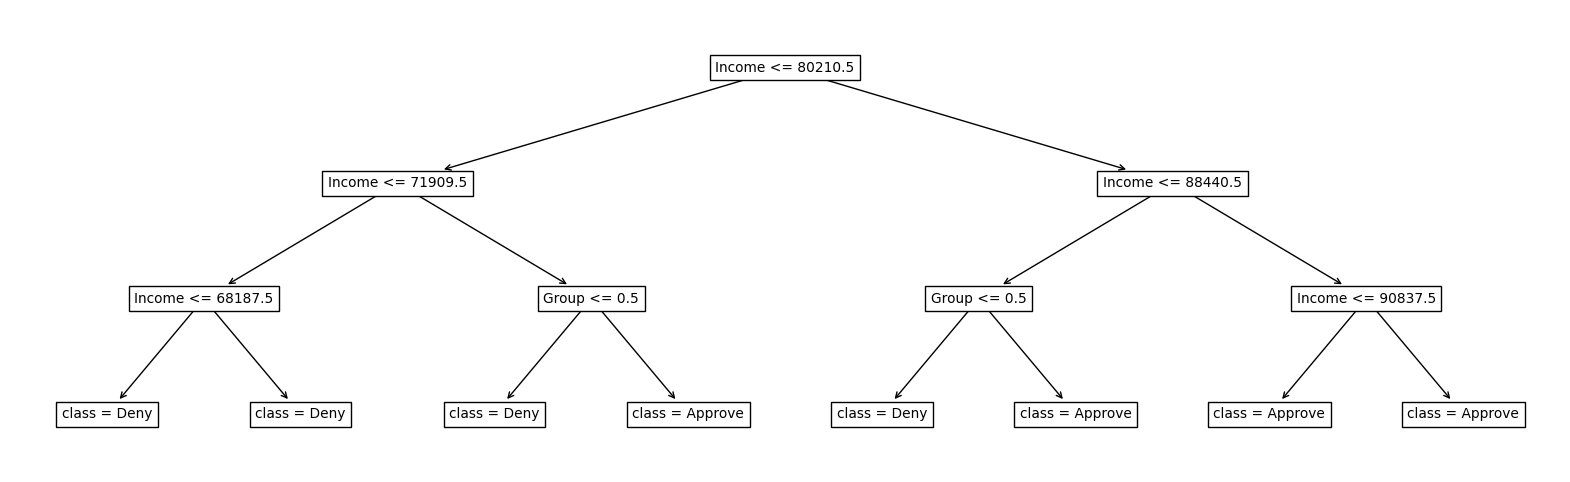

In [11]:
def visualize_model(model, feature_names, class_names=["Deny", "Approve"], impurity=False):
    plot_list = tree.plot_tree(model, feature_names=feature_names, class_names=class_names, impurity=impurity)
    [process_plot_item(item) for item in plot_list]

def process_plot_item(item):
    split_string = item.get_text().split("\n")
    if split_string[0].startswith("samples"):
        item.set_text(split_string[-1])
    else:
        item.set_text(split_string[0])

plt.figure(figsize=(20, 6))
plot_list = visualize_model(model_baseline, feature_names=X_train.columns)

For instance, consider an applicant in Group B, who has an income of 75k. Then,

* We start at the top of the flow chart. the applicant has an income of 75k, so Income <= 80210.5 is true, and we move to the left.
* Next, we check the income again. Since Income <= 71909.5 is false, we move to the right.
* The last thing to check is what group the applicant belongs to. The applicant belongs to Group B, so Group <= 0.5 is false, and we move to the right, where the model has decided to approve the applicant.

Total approvals: 36670
Group A: 11624 (31.7% of approvals)
Group B: 25046 (68.3% of approvals)

Overall accuracy: 92.66%
Group A: 93.61%
Group B: 91.72%

Sensitivity / True positive rate:
Group A: 93.24%
Group B: 86.21%


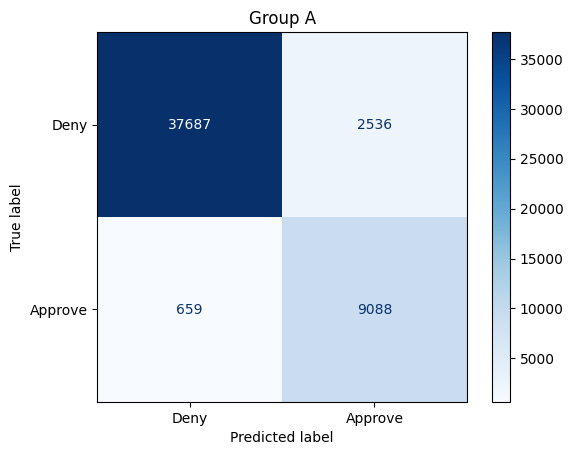

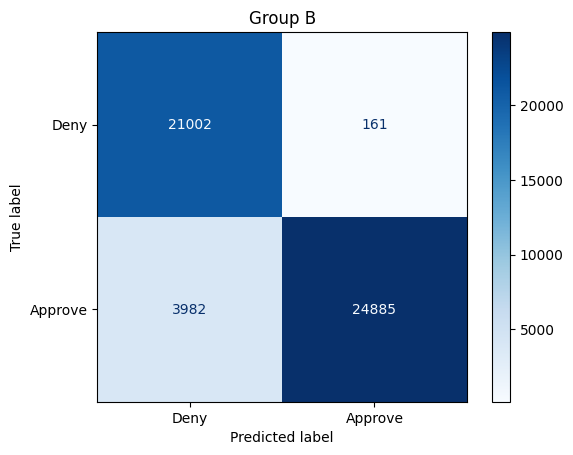

In [12]:
# New model

# Create new dataset with gender removed
X_train_unaware = X_train.drop(["Group"],axis=1)
X_test_unaware = X_test.drop(["Group"],axis=1)

# Train new model on new dataset
model_unaware = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
model_unaware.fit(X_train_unaware, y_train)

# Evaluate the model
preds_unaware = model_unaware.predict(X_test_unaware)
get_stats(X_test_unaware, y_test, model_unaware, X_test["Group"]==1, preds_unaware)

The new model is still biased in favor of Group B, but is now a bit more fair than the original model. But now, if you consider either equal accuracy or equal opportunity, the model is biased in favor of Group A! It's also important to note that the overall accuracy of the model has dropped -- for each group, the model is making slightly less accurate decisions.

Total approvals: 38241
Group A: 19869 (51.96% of approvals)
Group B: 18372 (48.04% of approvals)

Overall accuracy: 79.38%
Group A: 79.74%
Group B: 79.02%

Sensitivity / True positive rate:
Group A: 100.0%
Group B: 63.64%


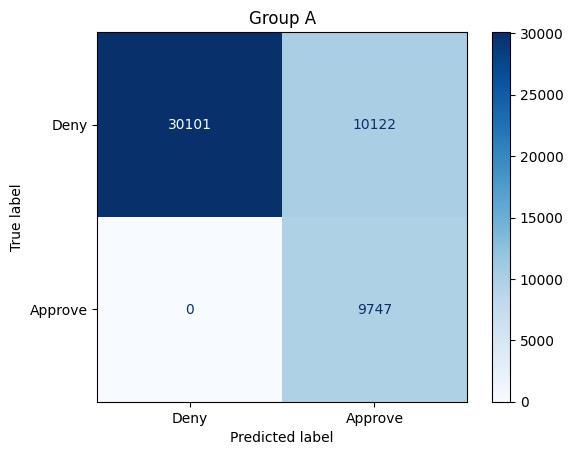

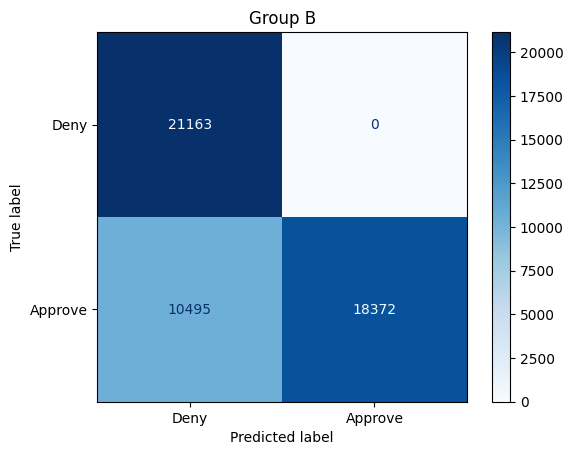

In [13]:
# New model

# Change the value of zero_threshold to hit the objective
zero_threshold = 0.11
one_threshold = 0.99

# Evaluate the model
test_probs = model_unaware.predict_proba(X_test_unaware)[:,1]
preds_approval = (((test_probs>zero_threshold)*1)*[X_test["Group"]==0] + ((test_probs>one_threshold)*1)*[X_test["Group"]==1])[0]
get_stats(X_test, y_test, model_unaware, X_test["Group"]==1, preds_approval)

This model acheives nearly equal representation in the pool of approved applicants from each group -- if demographic parity is what we care about, then this model is much more fair than the first two models. Accuracy is roughly the same for each group, but there is a substantial drop in overall accuracy for each group. If we examine the model for equal opportunity fairness, the model is biased in favor of Group A: all individuals from Group A who should be approved are approved, whereas only 63% of individuals from Group B who should be approved are approved. (This is similar to the dynamic in the first model, with the favored group switched -- that is, in the first model, nearly all individuals from Group B who should be approved were approved by the model.

## More info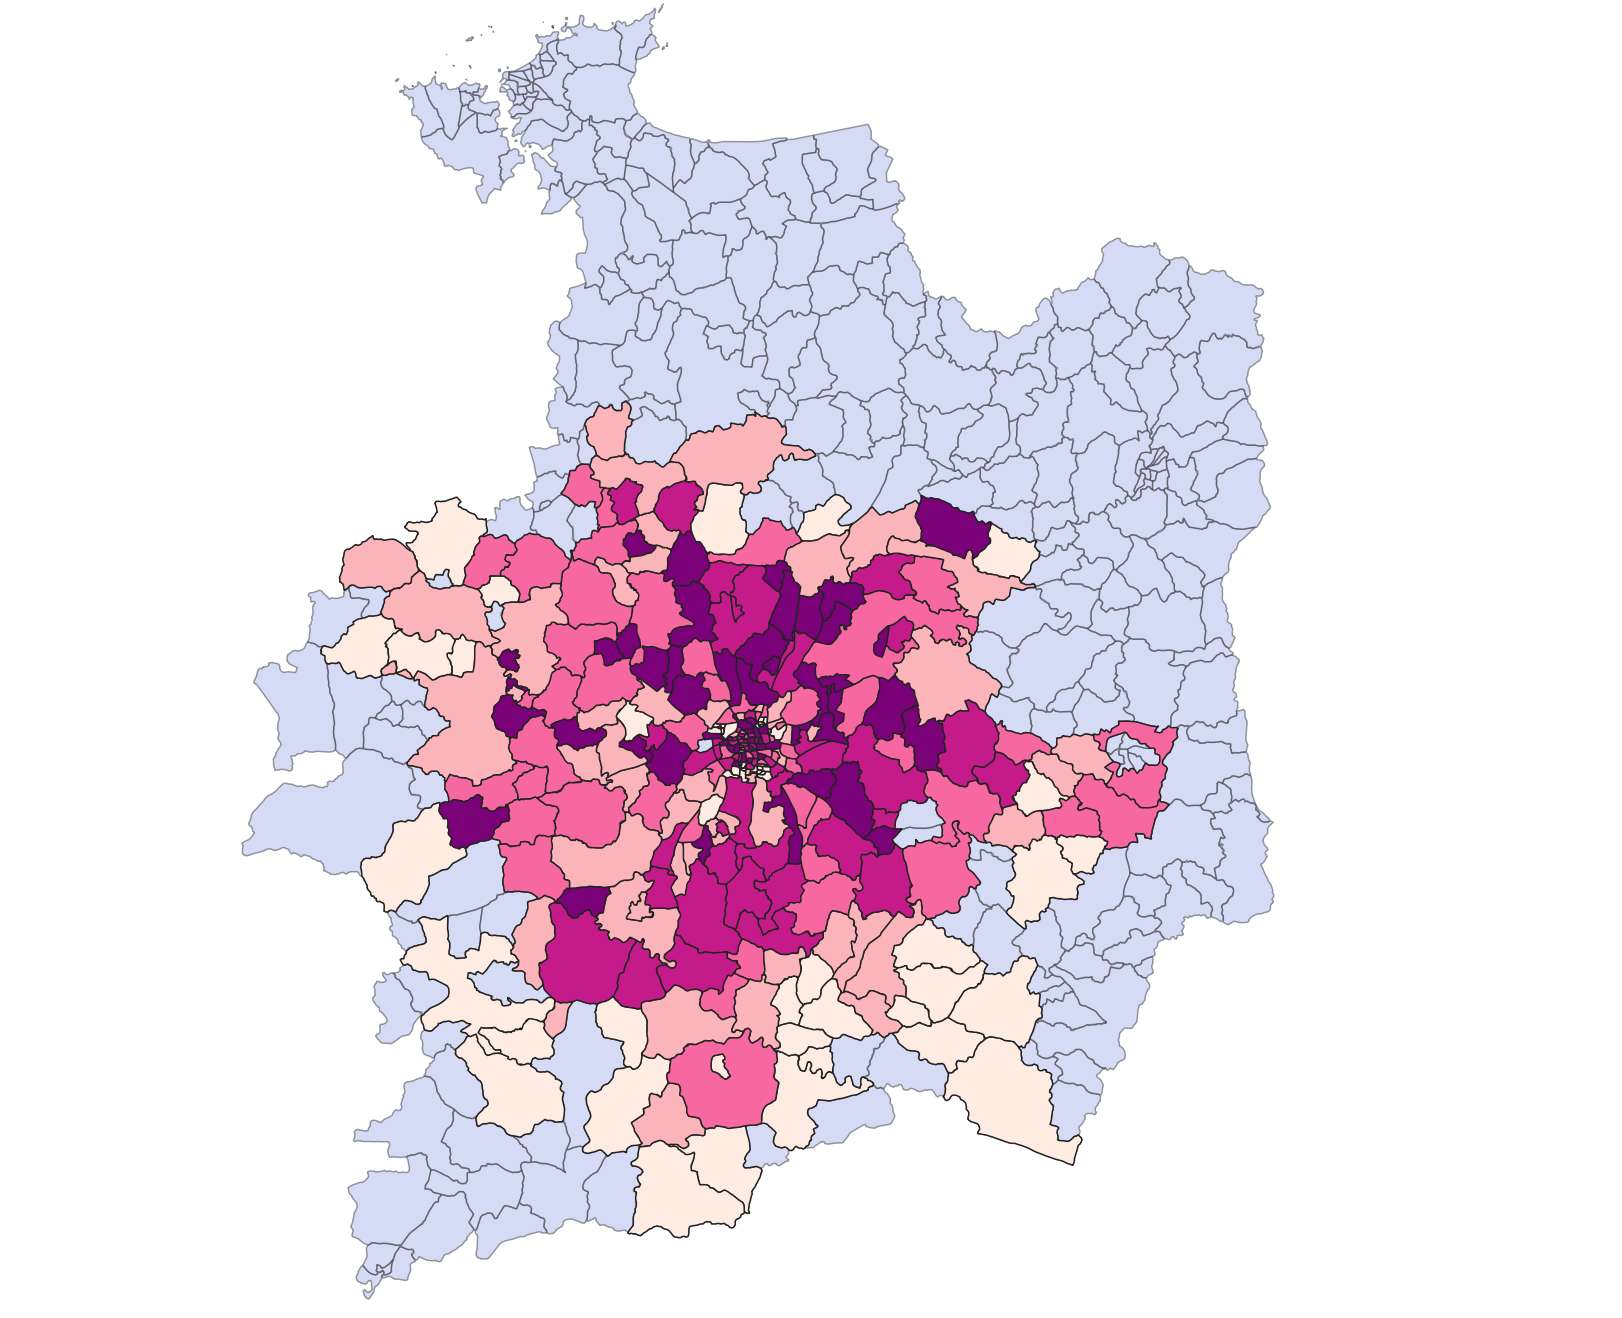

[THE IMPOSSIBILITY THEOREM OF MACHINE FAIRNESS](https://https://arxiv.org/pdf/2007.06024.pdf)

Historical Bias
* Historical bias arises even if data is perfectly measured and sampled, if the world as it is or was leads to a model that produces harmful outcomes. Such a system, even if it reflects the world accurately, can still inflict harm on a population. Considerations of historical bias often involve evaluating the representational harm (such as
reinforcing a stereotype) to a particular group.

Representation Bias
* Representation bias occurs when the development sample underrepresents some part of the population, and subsequently fails to
generalize well for a subset of the use population. Representation
bias can arise in several ways:
* (1) When defining the target population, if it does not reflect the use population. Data that is representative of
Boston, for example, may not be representative if used to
analyze the population of Indianapolis. Similarly, data representative of Boston 30 years ago will likely not reflect today’s
population.
* (2) When defining the target population, if contains underrepresented groups. Say the target population for a particular medical dataset is defined to be adults aged 18-40. There
are minority groups within this population: for example,
people who are pregnant may make up only 5% of the target
population. Even we sample perfectly, and even if the use
population is the same (adults 18-40), the model will likely
be less robust for those 5% of pregnant people because it has
less data to learn from.
* (3) When sampling from the target population, if the sampling method is limited or uneven. For example, the target population for modeling an infectious disease might be
all adults, but medical data may be available only for the
sample of people who were considered serious enough to
bring in for further screening. As a result, the development sample will represent a skewed subset of the target population. In statistics, this is typically referred to as sampling
bias.

Measurement Bias
* Measurement bias occurs when choosing, collecting, or computing features and labels to use in a prediction problem. Typically,
a feature or label is a proxy (a concrete measurement) chosen to
approximate some construct (an idea or concept) that is not directly
encoded or observable. For example, “creditworthiness” is an abstract construct that is often operationalized with a measureable
proxy like a credit score. Proxies become problematic when they
are poor reflections or the target construct and/or are generated
differently across groups, which can when:
* (1) The proxy is an oversimplification of a more complex
construct. Consider the prediction problem of deciding
whether a student will be successful (e.g., in a college admissions context). Fully capturing the outcome of “successful
student” in terms of a single measurable attribute is impossible because of its complexity. In cases such as these, algorithm designers may resort to a single available label such
as “GPA” [30], which ignores different indicators of success
present in different parts of the population.
* (2) The method of measurement varies across groups. For
example, consider factory workers at several different locations who are monitored to count the number of errors
that occur (i.e., observed number of errors is being used as a
proxy for work quality). If one location is monitored much
more stringently or frequently, there will be more errors observed for that group. This can also lead to a feedback loop
wherein the group is subject to further monitoring because
of the apparent higher rate of mistakes [5, 17].
* (3) The accuracy of measurement varies across groups. For
example, in medical applications, “diagnosed with condition
X” is often used as a proxy for “has condition X.” However,
structural discrimination can lead to systematically higher
rates of misdiagnosis or underdiagnosis in certain groups
[25, 35, 39]. For example, there are both gender and racial
disparities in diagnoses for conditions involving pain assessment [7, 24].

Aggregation Bias
* Aggregation bias arises when a one-size-fits-all model is used for
data in which there are underlying groups or types of examples that
should be considered differently. Underlying aggregation bias is an
assumption that the mapping from inputs to labels is consistent
across subsets of the data. In reality, this is often not the case. A
particular dataset might represent people or groups with different
backgrounds, cultures or norms, and a given variable can mean
something quite different across them. Aggregation bias can lead to
a model that is not optimal for any group, or a model that is fit to
the dominant population (e.g., if there is also representation bias).

Learning Bias
* Learning bias arises when modeling choices amplify performance
disparities across different examples in the data [26]. For example,
an important modeling choice is the objective function that an
ML algorithm learns to optimize during training. Typically, these
functions encode some measure of accuracy on the task (e.g., crossentropy loss for classification problems or mean squared error for
regression problems). However, issues can arise when prioritizing
one objective (e.g., overall accuracy) damages another (e.g., disparate impact) [31]. For example, minimizing cross-entropy loss
when building a classifier might inadvertently lead to a model with
more false positives than might be desirable in many contexts.

Evaluation Bias
* Evaluation bias occurs when the benchmark data used for a particular task does not represent the use population. A model is optimized on its training data, but its quality is often measured on
benchmarks (e.g., UCI datasets2
, Faces in the Wild3
, ImageNet4
).
This issue operates at a broader scale than other sources of bias:
a misrepresentative benchmark encourages the development and
deployment of models that perform well only on the subset of the
data represented by the benchmark data.
Evaluation bias ultimately arises because of a desire to quantitatively compare models against each other. Applying different
models to a set of external datasets attempts to serve this purpose,
but is often extended to make general statements about how good
a model is. Such generalizations are often not statistically valid
[42], and can lead to overfitting to a particular benchmark. This
is especially problematic if the benchmark suffers from historical,
representation or measurement bias.
Evaluation bias can also be exacerbated by the choice of metrics that are used to report performance. For example, aggregate
measures can hide subgroup underperformance, but these singular
measures are often used because they make it more straightforward to compare models and make a judgment about which one is
“better.” Just looking at one type of metric (e.g., accuracy) can also
hide disparities in other types of errors (e.g., false negative rate).

Deployment Bias
* Deployment bias arises when there is a mismatch between the
problem a model is intended to solve and the way in which it is
actually used. This often occurs when a system is built and evaluated as if it were fully autonomous, while in reality, it operates in a complicated sociotechnical system moderated by institutional structures and human decision-makers (Selbst et al. [43] refers to this as
the “framing trap”). In some cases, for example, systems produce
results that must first be interpreted by human decision-makers.
Despite good performance in isolation, they may end up causing
harmful consequences because of phenomena such as automation
or confirmation bias.